# Text classification with Quanvolutional layer + Attention + HQLSTM

# Import libraries

Imports for computations

In [503]:
# !pip install custatevec_cu12
# !pip install pennylane pennylane-lightning
import pennylane as qml
from pennylane import numpy as np
import torch
import torch.nn as nn
import pandas as pd
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torch.nn.functional as F
from tqdm.notebook import tqdm

yep

For plotting data

In [504]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")
sns.despine()
# plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc("axes", labelweight="bold", labelsize="large", titleweight="bold", titlepad=10)

%matplotlib inline

<Figure size 640x480 with 0 Axes>

For data preprocessing and text cleaning

In [505]:
# !pip install langdetect
# !pip install contractions
# !pip install emoji==1.4.1
# !pip install nltk

import re
import string
import emoji
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.corpus import stopwords
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from langdetect import detect, LangDetectException
import contractions
from nltk.tokenize import word_tokenize
from collections import Counter
from gensim.models import Word2Vec

stop_words = set(stopwords.words('english'))

lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\den1s\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\den1s\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\den1s\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\den1s\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Set seed for reproductivity

In [506]:
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)

In [507]:
num_qubits = 4
# device = "cuda" if torch.cuda.is_available() else "cpu"
# device = "cpu"
# dev = qml.device('qulacs.simulator', wires = range(num_qubits))
device = "cpu"
dev = qml.device("lightning.qubit", wires=range(num_qubits))
# dev = qml.device("default.tensor", method="tn", wires = range(num_qubits), **kwargs_tn)
dev

<lightning.qubit device (wires=4) at 0x26838348950>

# Import data, data preprocessing and analysis

We use "Cyberbullying Classification" dataset from Kaggle. You can acquire more information about the data by the following link: https://www.kaggle.com/datasets/andrewmvd/cyberbullying-classification/data

In [508]:
df = pd.read_csv('cyberbullying_tweets.csv')

In [509]:
df

,tweet_text,cyberbullying_type
0,"In other words #katandandre, your food was cra...",not_cyberbullying
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying
...,...,...
47687,"Black ppl aren't expected to do anything, depe...",ethnicity
47688,Turner did not withhold his disappointment. Tu...,ethnicity
47689,I swear to God. This dumb nigger bitch. I have...,ethnicity
47690,Yea fuck you RT @therealexel: IF YOURE A NIGGE...,ethnicity


In [510]:
df = df.rename(columns={'tweet_text': 'text', 'cyberbullying_type': 'sentiment'})

In [511]:
df.head()

,text,sentiment
0,"In other words #katandandre, your food was cra...",not_cyberbullying
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying


Define cleaning functions. Source: https://www.kaggle.com/code/ludovicocuoghi/detecting-bullying-tweets-pytorch-lstm-bert

In [512]:
# Clean emojis from text
def strip_emoji(text):
    return emoji.get_emoji_regexp().sub("", text)

# Remove punctuations, stopwords, links, mentions and new line characters
def strip_all_entities(text):
    text = re.sub(r'\r|\n', ' ', text.lower())  # Replace newline and carriage return with space, and convert to lowercase
    text = re.sub(r"(?:\@|https?\://)\S+", "", text)  # Remove links and mentions
    text = re.sub(r'[^\x00-\x7f]', '', text)  # Remove non-ASCII characters
    banned_list = string.punctuation
    table = str.maketrans('', '', banned_list)
    text = text.translate(table)
    text = ' '.join(word for word in text.split() if word not in stop_words)
    return text

# Clean hashtags at the end of the sentence, and keep those in the middle of the sentence by removing just the # symbol
def clean_hashtags(tweet):
    # Remove hashtags at the end of the sentence
    new_tweet = re.sub(r'(\s+#[\w-]+)+\s*$', '', tweet).strip()

    # Remove the # symbol from hashtags in the middle of the sentence
    new_tweet = re.sub(r'#([\w-]+)', r'\1', new_tweet).strip()

    return new_tweet

# Filter special characters such as & and $ present in some words
def filter_chars(text):
    return ' '.join('' if ('$' in word) or ('&' in word) else word for word in text.split())

# Remove multiple spaces
def remove_mult_spaces(text):
    return re.sub(r"\s\s+", " ", text)

# Function to check if the text is in English, and return an empty string if it's not
def filter_non_english(text):
    try:
        lang = detect(text)
    except LangDetectException:
        lang = "unknown"
    return text if lang == "en" else ""

# Expand contractions
def expand_contractions(text):
    return contractions.fix(text)

# Remove numbers
def remove_numbers(text):
    return re.sub(r'\d+', '', text)

# Lemmatize words
def lemmatize(text):
    words = word_tokenize(text)
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words]
    return ' '.join(lemmatized_words)

# Remove short words
def remove_short_words(text, min_len=2):
    words = text.split()
    long_words = [word for word in words if len(word) >= min_len]
    return ' '.join(long_words)

# Replace elongated words with their base form
def replace_elongated_words(text):
    regex_pattern = r'\b(\w+)((\w)\3{2,})(\w*)\b'
    return re.sub(regex_pattern, r'\1\3\4', text)

# Remove repeated punctuation
def remove_repeated_punctuation(text):
    return re.sub(r'[\?\.\!]+(?=[\?\.\!])', '', text)

# Remove extra whitespace
def remove_extra_whitespace(text):
    return ' '.join(text.split())

def remove_url_shorteners(text):
    return re.sub(r'(?:http[s]?://)?(?:www\.)?(?:bit\.ly|goo\.gl|t\.co|tinyurl\.com|tr\.im|is\.gd|cli\.gs|u\.nu|url\.ie|tiny\.cc|alturl\.com|ow\.ly|bit\.do|adoro\.to)\S+', '', text)

# Remove spaces at the beginning and end of the tweet
def remove_spaces_tweets(tweet):
    return tweet.strip()

# Remove short tweets
def remove_short_tweets(tweet, min_words=3):
    words = tweet.split()
    return tweet if len(words) >= min_words else ""

# Function to call all the cleaning functions in the correct order
def clean_tweet(tweet):
    tweet = strip_emoji(tweet)
    tweet = expand_contractions(tweet)
    tweet = filter_non_english(tweet)
    tweet = strip_all_entities(tweet)
    tweet = clean_hashtags(tweet)
    tweet = filter_chars(tweet)
    tweet = remove_mult_spaces(tweet)
    tweet = remove_numbers(tweet)
    tweet = lemmatize(tweet)
    tweet = remove_short_words(tweet)
    tweet = replace_elongated_words(tweet)
    tweet = remove_repeated_punctuation(tweet)
    tweet = remove_extra_whitespace(tweet)
    tweet = remove_url_shorteners(tweet)
    tweet = remove_spaces_tweets(tweet)
    tweet = remove_short_tweets(tweet)
    tweet = ' '.join(tweet.split())  # Remove multiple spaces between words
    return tweet

In [513]:
df['text_clean'] = [clean_tweet(tweet) for tweet in df['text']]

In [514]:
df.head()

,text,sentiment,text_clean
0,"In other words #katandandre, your food was cra...",not_cyberbullying,word katandandre food crapilicious mkr
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying,aussietv white mkr theblock imacelebrityau tod...
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying,classy whore red velvet cupcake
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying,meh thanks head concerned another angry dude t...
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying,isi account pretending kurdish account like is...


In [515]:
print(f'There are around {int(df["text_clean"].duplicated().sum())} duplicated tweets, we will remove them.')

There are around 6290 duplicated tweets, we will remove them.


In [516]:
df.drop_duplicates("text_clean", inplace=True)

In [517]:
df.sentiment.value_counts()

sentiment
religion               7917
age                    7819
ethnicity              7414
gender                 7278
not_cyberbullying      6063
other_cyberbullying    4911
Name: count, dtype: int64

As we can see, after cleaning classes are unbalanced so we will drop "other_cyberbullying" class as there is not enough data. Later we will oversample "not_cyberbullying" class.

In [518]:
df = df[df["sentiment"]!="other_cyberbullying"]

In [519]:
df['text_len'] = [len(text.split()) for text in df.text_clean]

In [520]:
# # Set target count
# target_count = 4901

# # Dropping random items to equalize the counts
# for column in df.columns:
#     current_count = df[column].value_counts().iloc[0]  # Get current count of the first category
#     if current_count > target_count:
#         # Calculate the number of items to drop
#         n_to_drop = current_count - target_count
        
#         # Select random indices to drop
#         indices_to_drop = df[df[column] == df[column].value_counts().index[0]].sample(n=n_to_drop, random_state=1).index

#         # Drop the selected rows
#         df = df.drop(indices_to_drop)

# # Resulting DataFrame value counts
# print("Value Counts after Dropping Random Items:")
# print(df.sentiment.value_counts())

In [521]:
df.sentiment.value_counts()

sentiment
religion             7917
age                  7819
ethnicity            7414
gender               7278
not_cyberbullying    6063
Name: count, dtype: int64

In [524]:
# Function to extract a middle portion of sorted DataFrame
def select_middle_texts(df, label, n):
    # Filter the DataFrame for a specific label
    df_filtered = df[df['sentiment'] == label]
    
    # Add a column for text length
    
    # Sort by text length
    df_sorted = df_filtered.sort_values(by='text_len')
    
    # Calculate middle index
    mid_index = len(df_sorted) // 2
    
    # Calculate start and end indices
    start_index = max(0, mid_index - n // 2)
    end_index = start_index + n
    
    # Select the middle 'n' rows
    middle_subset = df_sorted.iloc[start_index:end_index].drop(columns=['text_len'])
    
    return middle_subset

# Selection criteria
value_counts = {
    'sentiment': 750,
    'religion': 750,
    'age': 750,
    'gender': 750,
    'not_cyberbullying': 3000
}

# Collect results for each label
results = []

for label, n in value_counts.items():
    subset = select_middle_texts(df, label, n)
    results.append(subset)

# Concatenate results into a final DataFrame
df_result = pd.concat(results).reset_index(drop=True)

In [525]:
df_result['sentiment'].value_counts()

sentiment
not_cyberbullying    3000
religion              750
age                   750
gender                750
Name: count, dtype: int64

In [526]:
df_result['sentiment'] = df_result['sentiment'].replace({'religion':1,'age':1,'ethnicity':1,'gender':1,'not_cyberbullying':0})

C:\Users\den1s\AppData\Local\Temp\ipykernel_12612\1991023214.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_result['sentiment'] = df_result['sentiment'].replace({'religion':1,'age':1,'ethnicity':1,'gender':1,'not_cyberbullying':0})


In [529]:
df_result['text_len'] = [len(text.split()) for text in df_result.text]

In [530]:
mean_len = np.mean(df['text_len'])
mean_len

14.270806500232935

In [531]:
df = df_result

In [532]:
df

,text,sentiment,text_clean,text_len
0,not even sure he understands what he just ramb...,1,even sure understands ramble everyone right op...,39
1,ISIS and all those other Terrorist organisatio...,1,isi terrorist organisation muslim follow basic...,42
2,That's what these idiots have been programmed ...,1,idiot programmed believe look actual number mu...,40
3,Sorry but don't say that you are also a part o...,1,sorry say also part bjp grand plan polarise hi...,30
4,wow what a family person u r! sponsering terro...,1,wow family person sponsering terrorism kashmir...,29
...,...,...,...,...
5245,@GerardGeorges4 @AlsisiOfficial Word is that t...,0,word ypgypj first time encroached raqqa provin...,22
5246,@GetEmEasy that don't make u a hater..if u sai...,0,make haterif said think good would hateri thin...,27
5247,@ottomanland @loveconcursall Brilliant how the...,0,brilliant english spy israeli got erdogan let ...,21
5248,RT @Yonadav7: Elder Of Ziyon - Israel News: Th...,0,rt elder ziyon israel news collection charlie ...,16


C:\Users\den1s\AppData\Local\Temp\ipykernel_12612\631618343.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='text_len', data=df[df['text_len']<10], palette='mako')


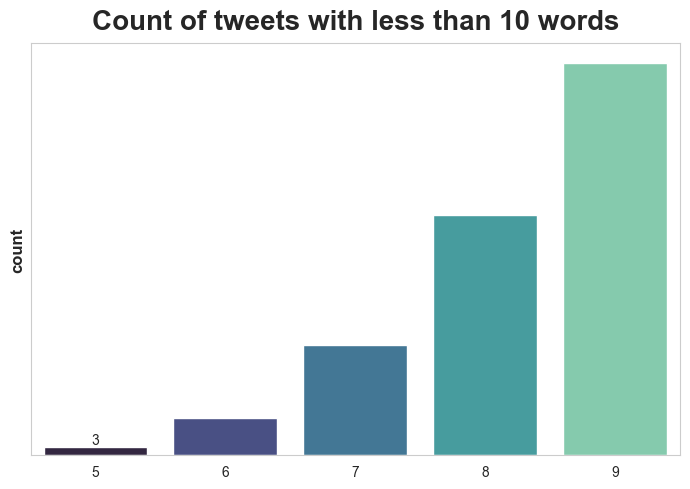

In [533]:
plt.figure(figsize=(7,5))
ax = sns.countplot(x='text_len', data=df[df['text_len']<10], palette='mako')
plt.title('Count of tweets with less than 10 words', fontsize=20)
plt.yticks([])
ax.bar_label(ax.containers[0])
plt.ylabel('count')
plt.xlabel('')
plt.show()

C:\Users\den1s\AppData\Local\Temp\ipykernel_12612\2060477503.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='text_len', data=df[(df['text_len']<=1000) & (df['text_len']>10)], palette='Blues_r')


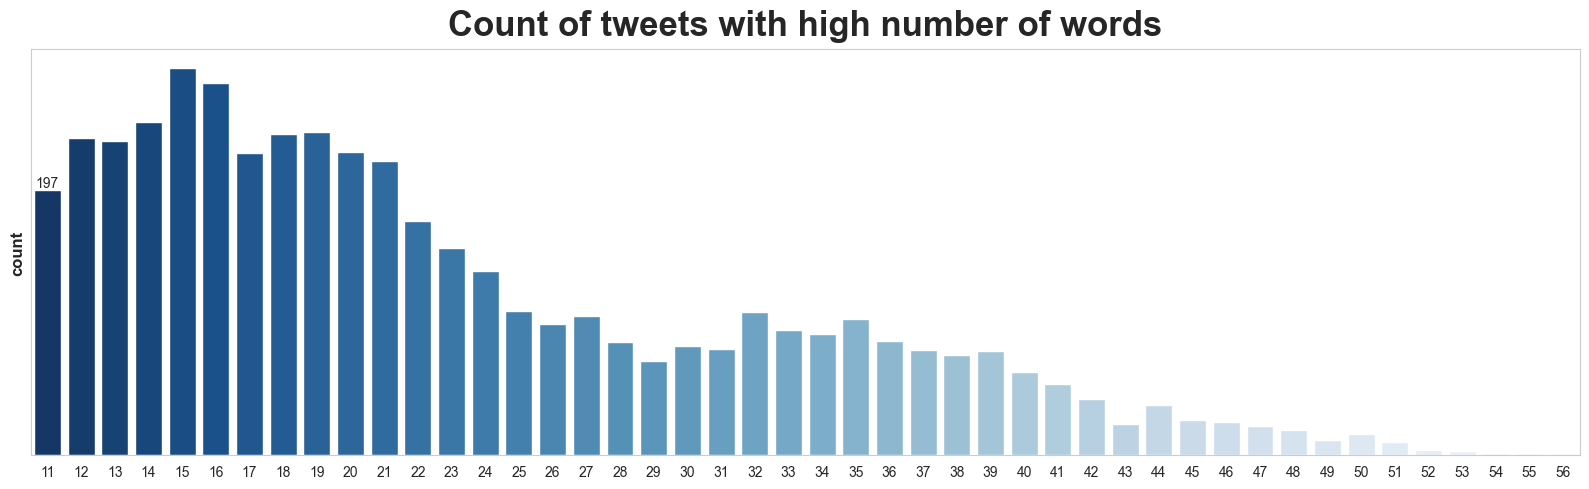

In [534]:
plt.figure(figsize=(16,5))
ax = sns.countplot(x='text_len', data=df[(df['text_len']<=1000) & (df['text_len']>10)], palette='Blues_r')
plt.title('Count of tweets with high number of words', fontsize=25)
plt.yticks([])
ax.bar_label(ax.containers[0])
plt.ylabel('count')
plt.xlabel('')
plt.show()

In [535]:
max_len = np.max(df['text_len'])
max_len

56

In [536]:
mean_len = np.mean(df['text_len'])
mean_len

21.860380952380954

Text tokenization

In [309]:
def Tokenize(column, seq_len):
    ##Create vocabulary of words from column
    corpus = [word for text in column for word in text.split()]
    count_words = Counter(corpus)
    sorted_words = count_words.most_common()
    vocab_to_int = {w:i+1 for i, (w,c) in enumerate(sorted_words)}

    ##Tokenize the columns text using the vocabulary
    text_int = []
    for text in column:
        r = [vocab_to_int[word] for word in text.split()]
        text_int.append(r)
    ##Add padding to tokens
    features = np.zeros((len(text_int), seq_len), dtype = int)
    for i, review in enumerate(text_int):
        if len(review) <= seq_len:
            zeros = list(np.zeros(seq_len - len(review)))
            new = zeros + review
        else:
            new = review[: seq_len]
        features[i, :] = np.array(new)

    return sorted_words, features

In [310]:
vocabulary, tokenized_column = Tokenize(df["text_clean"], max_len)

In [311]:
X = df['text_clean']
y = df['sentiment']

In [312]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

Text embedding with pre-trained Word2vec model

In [313]:
Word2vec_train_data = list(map(lambda x: x.split(), X_train))

In [314]:
EMBEDDING_DIM = 200

In [315]:
word2vec_model = Word2Vec(Word2vec_train_data, vector_size=EMBEDDING_DIM)

In [316]:
VOCAB_SIZE = len(vocabulary) + 1 #+1 for the padding

In [317]:
# Define an empty embedding matrix of shape (VOCAB_SIZE, EMBEDDING_DIM)
embedding_matrix = np.zeros((VOCAB_SIZE, EMBEDDING_DIM))

# Fill the embedding matrix with pre-trained values from word2vec
for word, token in vocabulary:
    # Check if the word is present in the word2vec model's vocabulary
    if word in word2vec_model.wv.key_to_index:
        # If the word is present, retrieve its embedding vector and add it to the embedding matrix
        embedding_vector = word2vec_model.wv[word]
        embedding_matrix[token] = embedding_vector

# Print the shape of the embedding matrix
print("Embedding Matrix Shape:", embedding_matrix.shape)

Embedding Matrix Shape: (37605, 200)


In [318]:
X = tokenized_column
y = df['sentiment'].values

In [319]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

Oversampling

In [320]:
ros = RandomOverSampler()
X_train_os, y_train_os = ros.fit_resample(np.array(X_train),np.array(y_train))

In [321]:
X_train_os.shape

(31335, 31)

Finally, we define our preprocessed dataset and loaders

In [350]:
train_data = TensorDataset(torch.from_numpy(X_train_os), torch.from_numpy(y_train_os))
test_data = TensorDataset(torch.from_numpy(X_test), torch.from_numpy(y_test))

In [351]:
BATCH_SIZE = 64

In [352]:
train_loader = DataLoader(train_data, shuffle=True, batch_size=BATCH_SIZE, drop_last=True)
test_loader = DataLoader(test_data, shuffle=False, batch_size=BATCH_SIZE, drop_last=True)

# Implementation of the classical model

In this paragraph we will implement model with classical convolution and LSTM in order to compare it with its hybrid-quantum analogue

In [353]:
class Attention(nn.Module):
    def __init__(self, hidden_dim):
        super(Attention, self).__init__()
        # The attention linear layer which transforms the input data to the hidden space
        self.attn = nn.Linear(hidden_dim * 2, hidden_dim )
        # The linear layer that calculates the attention scores
        self.v = nn.Linear(hidden_dim, 1, bias=False)

    def forward(self, hidden, encoder_outputs):
        seq_len = encoder_outputs.size(1)
        # Concatenate the last two hidden states in case of a bidirectional LSTM
        hidden = hidden[-1]
        # Repeat the hidden state across the sequence length
        hidden_repeated = hidden.unsqueeze(1).repeat(1, seq_len, 1)
        # Calculate attention weights
        attn_weights = torch.tanh(self.attn(torch.cat((hidden_repeated, encoder_outputs), dim=2)))
        # Compute attention scores
        attn_weights = self.v(attn_weights).squeeze(2)
        # Apply softmax to get valid probabilities
        return nn.functional.softmax(attn_weights, dim=1)

In [354]:
class ClassicalModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, in_channels, out_channels, kernel_size, stride, padding, hidden_dim, num_classes, lstm_layers):
        super(ClassicalModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = lstm_layers

        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, lstm_layers, batch_first=True)
        self.attention = Attention(hidden_dim)
        self.fc = nn.Linear(hidden_dim, num_classes)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, x, hidden):
        # Transform words to embeddings
        embedded = self.embedding(x)
        # embedded = self.conv(embedded.unsqueeze(1))
        # # Pass embeddings to LSTM
        # out, hidden = self.lstm(embedded.reshape(-1, embedded.size(1)*embedded.size(2), embedded.size(-1)), hidden)
        out, hidden = self.lstm(embedded, hidden)
        # Calculate attention weights
        attn_weights = self.attention(hidden[0], out)
        # Calculate context vector by taking the weighted sum of LSTM outputs
        context = attn_weights.unsqueeze(1).bmm(out).squeeze(1)
        # Classify the context vector
        out = self.softmax(self.fc(context))
        return out, hidden

    def init_hidden(self, batch_size):
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_dim)
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_dim)
        return h0, c0

# Implementation of the hybrid-quantum model

In [406]:
@qml.qnode(dev, interface='torch')
def quanvcirc(patch, weights, wires=range(num_qubits)):
    # Angle embedding of the patch (reshape to match expected size)
    qml.AngleEmbedding(patch, wires=wires, rotation='Y')

    # Apply RX rotations based on the weights
    qml.RX(weights[0][0], wires=0)
    qml.RX(weights[0][1], wires=1)
    qml.RY(weights[1][0], wires=2)
    qml.RY(weights[1][1], wires=3)

    # Apply CNOT gates
    qml.CNOT(wires=[0, 1])
    qml.CNOT(wires=[1, 2])
    qml.CNOT(wires=[2, 3])
    qml.CNOT(wires=[3, 0])
    # Apply RY rotations based on the weights


    # Return the expectation values of Pauli-Z measurements on all qubits
    return qml.expval(qml.PauliZ(0))

In [407]:
print(qml.draw(quanvcirc)(np.ones((1, 4)), np.ones((2, 2))))

0: ─╭AngleEmbedding(M0)──RX(1.00)─╭●───────╭X─┤  <Z>
1: ─├AngleEmbedding(M0)──RX(1.00)─╰X─╭●────│──┤     
2: ─├AngleEmbedding(M0)──RY(1.00)────╰X─╭●─│──┤     
3: ─╰AngleEmbedding(M0)──RY(1.00)───────╰X─╰●─┤     

M0 = 
[[1. 1. 1. 1.]]


In [408]:
class QuanConv2D(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding):
        super(QuanConv2D, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding

        # Define weights and biases as trainable parameters
        self.weights = nn.Parameter(
            torch.randn(out_channels, in_channels, kernel_size, kernel_size), requires_grad = True
        )

    def forward(self, input):
        # Extract dimensions
        batch_size, in_channels, input_height, input_width = input.shape

        # Calculate output dimensions
        output_height = (input_height - self.kernel_size + 2 * self.padding) // self.stride + 1
        output_width = (input_width - self.kernel_size + 2 * self.padding) // self.stride + 1

        # Initialize output tensor
        output = torch.zeros(batch_size, self.out_channels, output_height, output_width)

        # If padding is required, add it to the input
        if self.padding > 0:
            input = F.pad(input, (self.padding, self.padding, self.padding, self.padding))

        # Perform convolution
        for b in range(batch_size):
            for c_out in range(self.out_channels):
                for h in range(output_height):
                    for w in range(output_width):
                        h_start = h * self.stride
                        h_end = h_start + self.kernel_size
                        w_start = w * self.stride
                        w_end = w_start + self.kernel_size

                        # Slice the input for the current window
                        input_slice = input[b, :, h_start:h_end, w_start:w_end]

                        # Perform element-wise multiplication and sum with bias
                        output[b, c_out, h, w] = quanvcirc(input_slice.reshape(1, self.kernel_size * self.kernel_size), self.weights[c_out].squeeze(0))
        return output

In [409]:
qdi_reps1 = 2
qdi_reps2 = 2
qdi_depth = 1

In [410]:
@qml.qnode(dev, interface='torch', diff_method="adjoint")
def qdi_circuit(weights, input_array, wires=range(num_qubits)):
    for r in range(qdi_reps1):
        for i in range(len(wires)):
            qml.RX(weights[r][i], wires=wires[i])
        for j in range(len(wires)-1):
            qml.CNOT(wires=[wires[j], wires[j+1]])
        qml.CNOT(wires=[wires[len(wires)-1], wires[0]])
        # qml.Barrier()
    for d in range(qdi_depth):
        qml.AngleEmbedding(input_array, wires=range(num_qubits), rotation='Z')
        for r in range(qdi_reps2):
            for i in range(len(wires)):
                qml.RX(weights[qdi_reps1+d*r][i], wires=wires[i])
            for j in range(len(wires)-1):
                qml.CNOT(wires=[wires[j], wires[j+1]])
            qml.CNOT(wires=[wires[len(wires)-1], wires[0]])
            # qml.Barrier()
        # qml.Barrier()
    return [qml.expval(qml.PauliY(w)) for w in wires]

In [411]:
print(qml.draw(qdi_circuit)(np.ones((qdi_reps1 + qdi_reps2, num_qubits)), np.ones((4, 4))))

0: ──RX(1.00)─╭●───────╭X──RX(1.00)─╭●───────╭X─╭AngleEmbedding(M0)──RX(1.00)─╭●───────╭X──RX(1.00)
1: ──RX(1.00)─╰X─╭●────│───RX(1.00)─╰X─╭●────│──├AngleEmbedding(M0)──RX(1.00)─╰X─╭●────│───RX(1.00)
2: ──RX(1.00)────╰X─╭●─│───RX(1.00)────╰X─╭●─│──├AngleEmbedding(M0)──RX(1.00)────╰X─╭●─│───RX(1.00)
3: ──RX(1.00)───────╰X─╰●──RX(1.00)───────╰X─╰●─╰AngleEmbedding(M0)──RX(1.00)───────╰X─╰●──RX(1.00)

──╭●───────╭X─┤  <Y>
──╰X─╭●────│──┤  <Y>
─────╰X─╭●─│──┤  <Y>
────────╰X─╰●─┤  <Y>

M0 = 
[[1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]]


In [439]:
class HQLSTMCell(nn.Module):
    def __init__(self, input_size, hidden_size, num_qubits):
        super(HQLSTMCell, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size

        # Combined weights for efficiency
        self.W_input = nn.Parameter(torch.rand(4 * num_qubits, input_size), requires_grad = True).float()
        self.W_hid = nn.Parameter(torch.rand(4 * num_qubits, hidden_size), requires_grad = True).float()
        self.W_quan = nn.Parameter(torch.zeros(4, qdi_reps1 + qdi_reps2, num_qubits), requires_grad = True).float()
        self.W = nn.Parameter(torch.rand(4, hidden_size, num_qubits), requires_grad = True).float()

    def forward(self, x, hidden):
        h_prev, c_prev = hidden

        yield_input = F.linear(x, self.W_input)
        yield_hidden = F.linear(h_prev, self.W_hid)
        # Concatenate input and previous hidden state
        combined = yield_input + yield_hidden
        # combined = torch.cat((yield_input, yield_hidden), dim=1)

        # Apply linear transformation

        # Split into gates
        # combined = torch.cat([torch.stack(qdi_circuit(self.W_quan[i], combined[:, i:i*num_qubits].reshape(-1, num_qubits))) for i in range(num_qubits)], dim = 0)
        i_gate = F.linear(torch.stack(qdi_circuit(self.W_quan[0], combined[:, :num_qubits].reshape(-1, num_qubits))).T.float(), self.W[0])
        f_gate = F.linear(torch.stack(qdi_circuit(self.W_quan[1], combined[:, num_qubits:2*num_qubits].reshape(-1, num_qubits))).T.float(), self.W[1])
        g_gate = F.linear(torch.stack(qdi_circuit(self.W_quan[2], combined[:, 2*num_qubits:3*num_qubits].reshape(-1, num_qubits))).T.float(), self.W[2])
        o_gate = F.linear(torch.stack(qdi_circuit(self.W_quan[3], combined[:, 3*num_qubits:4*num_qubits].reshape(-1, num_qubits))).T.float(), self.W[3])



        # combined = torch.cat((i_gate, f_gate, g_gate, o_gate), dim=0).float()
        # gates = F.linear(combined, self.W)

        # # Split into gates
        # i_gate, f_gate, g_gate, o_gate = gates.chunk(4, 0)

        # Apply non-linearities
        i_gate = torch.sigmoid(i_gate)
        f_gate = torch.sigmoid(f_gate)
        g_gate = torch.tanh(g_gate)
        o_gate = torch.sigmoid(o_gate)

        # Update cell state
        c_next = (f_gate * c_prev) + (i_gate * g_gate)

        # Update hidden state
        h_next = o_gate * torch.tanh(c_next)

        return h_next, c_next


class HQLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_qubits, num_layers=1):
        super(HQLSTM, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm_cells = nn.ModuleList([HQLSTMCell(input_size if l==0 else hidden_size, hidden_size, num_qubits) for l in range(num_layers)])


    def forward(self, x, hidden=None):
        batch_size, seq_len, _ = x.size()

        if hidden is None:
             h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size)
             c0 = torch.zeros(self.num_layers, batch_size, self.hidden_size)
        else:
            h0, c0 = hidden

        output_seq = []

        for t in range(seq_len):
            input_t = x[:, t, :] # input at current timestep
            # print(f'step:{t}/{seq_len}, hidden:')

            new_h = []
            new_c = []

            for layer in range(self.num_layers):

                # Get hidden state for current layer
                h_t, c_t = self.lstm_cells[layer](input_t, (h0[layer], c0[layer]))

                # Update hidden states for next timestep, for current layer
                new_h.append(h_t)
                new_c.append(c_t)
                input_t = h_t # The output of current layer is input for the next

            h0 = torch.stack(new_h)
            c0 = torch.stack(new_c)
            # Append hidden state at the topmost layer
            output_seq.append(h_t.unsqueeze(1))

        # Concatenate the outputs over the sequence length
        output_seq = torch.cat(output_seq, dim=1) # output_seq is of shape (batch_size, seq_len, hidden_size)

        return output_seq, (h0, c0)


Toy hybrid-quantum model for benchmarking

In [440]:
class ToyHQModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, in_channels, out_channels, kernel_size, stride, padding, hidden_dim, num_qubits, num_classes, lstm_layers):
        super(ToyHQModel, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
        self.num_layers = lstm_layers
        self.hidden_dim = hidden_dim

        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.attention = Attention(hidden_dim)
        # self.conv = QuanConv2D(self.in_channels, self.out_channels, self.kernel_size, self.stride, self.padding)
        self.lstm = HQLSTM(embedding_dim, hidden_dim, num_qubits, lstm_layers)
        self.fc = nn.Linear(hidden_dim, num_classes)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        # Transform words to embeddings
        embedded = self.embedding(x)
        # x = self.conv(x.unsqueeze(1))
        # Pass embeddings to LSTM
        out, hidden = self.lstm(embedded)
        # Calculate attention weights
        attn_weights = self.attention(hidden[0], out)
        # Calculate context vector by taking the weighted sum of LSTM outputs
        context = attn_weights.unsqueeze(1).bmm(out).squeeze(1)
        # Classify the context vector
        out = self.softmax(self.fc(context))
        return out

    def init_hidden(self, batch_size):
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_dim)
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_dim)
        return h0, c0

In [441]:
class HybridQuantumModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, in_channels, out_channels, kernel_size, stride, padding, hidden_dim, num_qubits, num_classes, lstm_layers):
        super(HybridQuantumModel, self).__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = HQLSTM(embedding_dim, hidden_dim, num_qubits, lstm_layers)
        self.attention = Attention(hidden_dim)
        self.fc = nn.Linear(hidden_dim, num_classes)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        # Transform words to embeddings
        embedded = self.embedding(x)
        # embedded = self.conv(embedded.unsqueeze(1)).to(device)
        # Pass embeddings to LSTM
        # out, hidden = self.lstm(embedded.reshape(-1, embedded.size(1)*embedded.size(2), embedded.size(-1)))
        out, hidden = self.lstm(embedded)
        # Calculate attention weights
        attn_weights = self.attention(hidden[0], out)
        # Calculate context vector by taking the weighted sum of LSTM outputs
        context = attn_weights.unsqueeze(1).bmm(out).squeeze(1)
        # Classify the context vector
        out = self.softmax(self.fc(context))
        return out

# Training the models

In [442]:
NUM_CLASSES = 5 #We are dealing with a multiclass classification of 5 classes
HIDDEN_DIM = 16 #number of neurons of the internal state (internal neural network in the LSTM)
LSTM_LAYERS = 1 #Number of stacked LSTM layers
IN_CHANNELS = 1
OUT_CHANNELS = 5
KERNEL_SIZE = 2
STRIDE = 1
PADDING = 1


LR = 0.001 #Learning rate
EPOCHS = 10 #Number of training epoch

criterion = nn.NLLLoss()

In [434]:
classical_model = ClassicalModel(VOCAB_SIZE, EMBEDDING_DIM, IN_CHANNELS, OUT_CHANNELS, KERNEL_SIZE, STRIDE, PADDING, HIDDEN_DIM, NUM_CLASSES, LSTM_LAYERS)
classical_model = classical_model
# classical_model = torch.compile(classical_model)

cl_optimizer = torch.optim.AdamW(classical_model.parameters(), lr=LR, weight_decay = 5e-6)

print(classical_model)

ClassicalModel(
  (embedding): Embedding(37605, 200)
  (conv): Conv2d(1, 5, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (lstm): LSTM(200, 16, batch_first=True)
  (attention): Attention(
    (attn): Linear(in_features=32, out_features=16, bias=True)
    (v): Linear(in_features=16, out_features=1, bias=False)
  )
  (fc): Linear(in_features=16, out_features=5, bias=True)
  (softmax): LogSoftmax(dim=1)
)


In [435]:
def initialize_weights(model):
    for name, param in model.named_parameters():
        if 'embedding' in name:
            nn.init.uniform_(param, -0.1, 0.1)
        elif 'lstm' in name:
            if 'weight' in name:
                nn.init.orthogonal_(param)
            elif 'bias' in name:
                nn.init.constant_(param, 0)
        elif 'fc' in name:
            nn.init.xavier_uniform_(param)

In [436]:
hybrid_quantum_model = HybridQuantumModel(VOCAB_SIZE, EMBEDDING_DIM, IN_CHANNELS, OUT_CHANNELS, KERNEL_SIZE, STRIDE, PADDING, HIDDEN_DIM, num_qubits, NUM_CLASSES, LSTM_LAYERS)
# initialize_weights(hybrid_quantum_model)


# hybrid_quantum_model = torch.compile(hybrid_quantum_model)

hq_optimizer = torch.optim.AdamW(hybrid_quantum_model.parameters(), lr=LR, weight_decay = 5e-6)

print(hybrid_quantum_model)

HybridQuantumModel(
  (embedding): Embedding(37605, 200)
  (lstm): HQLSTM(
    (lstm_cells): ModuleList(
      (0): HQLSTMCell(
        (relu): ReLU()
      )
    )
  )
  (attention): Attention(
    (attn): Linear(in_features=32, out_features=16, bias=True)
    (v): Linear(in_features=16, out_features=1, bias=False)
  )
  (fc): Linear(in_features=16, out_features=5, bias=True)
  (softmax): LogSoftmax(dim=1)
)


In [437]:
import time

def train(model, criterion, optimizer,
          train_dataloader, test_dataloader, num_epochs):

    train_losses = np.zeros(num_epochs)
    test_losses = np.zeros(num_epochs)

    train_accuracy_arr = np.zeros(num_epochs)
    test_accuracy_arr = np.zeros(num_epochs)

    for i_epoch in tqdm(range(num_epochs)):
        it = 0
        train_loss = 0
        test_loss = 0

        train_accuracy = 0
        test_accuracy = 0

        # train step
        model.train()
        for batch in train_dataloader:
            start_time = time.time()
            X = batch[0]
            y = batch[1]

            h = model.init_hidden(y.size(0))
            # model forward-pass
            preds, h = model(X, h)

            # model backward-pass
            optimizer.zero_grad() # t.grad = torch.tensor([0., 0., 0.])
            loss = criterion(preds, y)
            loss.backward()
            optimizer.step() # t = t - lr * t.grad
            end_time = time.time()
            execution_time = end_time - start_time

            # save loss and accuracy
            train_loss += loss.detach().cpu().numpy()
            # print(f'batch: {it+1}/{len(train_dataloader)}, loss: {train_loss/(it+1):.4f}, time: {execution_time:.4f}')
            it += 1
            train_accuracy += (preds.argmax(-1).detach() == y).cpu().numpy().mean()


        train_loss /= len(train_dataloader)
        train_accuracy /= len(train_dataloader)
        train_losses[i_epoch] = train_loss
        train_accuracy_arr[i_epoch] = train_accuracy

        # test step
        model.eval()
        for batch in test_dataloader:
            X = batch[0]
            y = batch[1]

            h = model.init_hidden(y.size(0))

            with torch.no_grad():
                # model forward-pass
                preds, h = model(X, h)
                loss = criterion(preds, y)

                # save loss and accuracy
                test_loss += loss.detach().cpu().numpy()
                test_accuracy += (preds.argmax(-1) == y).cpu().numpy().mean()


        test_loss /= len(test_dataloader)
        test_accuracy /= len(test_dataloader)

        test_losses[i_epoch] = test_loss
        test_accuracy_arr[i_epoch] = test_accuracy

    return train_losses, test_losses, train_accuracy_arr, test_accuracy_arr

def train_for_hqnn(model, criterion, optimizer,
          train_dataloader, test_dataloader, num_epochs):

    train_losses = np.zeros(num_epochs)
    test_losses = np.zeros(num_epochs)

    train_accuracy_arr = np.zeros(num_epochs)
    test_accuracy_arr = np.zeros(num_epochs)

    for i_epoch in tqdm(range(num_epochs)):
        it = 0

        train_loss = 0
        test_loss = 0

        train_accuracy = 0
        test_accuracy = 0

        # train step
        model.train()
        for batch in train_dataloader:
            start_time = time.time()
            X = batch[0]
            y = batch[1]

            # model forward-pass
            preds = model(X)

            # model backward-pass
            optimizer.zero_grad() # t.grad = torch.tensor([0., 0., 0.])
            loss = criterion(preds, y)
            loss.backward()
            optimizer.step() # t = t - lr * t.grad
            end_time = time.time()
            execution_time = end_time - start_time

            # save loss and accuracy
            train_loss += loss.detach().cpu().numpy()
            print(f'it: {it+1}/{len(train_dataloader)}, loss: {train_loss/(it+1):.4f}, time: {execution_time:.4f}')
            it += 1
            train_accuracy += (preds.argmax(-1).detach() == y).cpu().numpy().mean()


        train_loss /= len(train_dataloader)
        train_accuracy /= len(train_dataloader)
        train_losses[i_epoch] = train_loss

        train_accuracy_arr[i_epoch] = train_accuracy

        # test step
        model.eval()
        for batch in test_dataloader:
            X = batch[0]
            y = batch[1]


            with torch.no_grad():
                # model forward-pass
                preds = model(X)
                loss = criterion(preds, y)

                # save loss and accuracy
                test_loss += loss.detach().cpu().numpy()
                test_accuracy += (preds.argmax(-1) == y).cpu().numpy().mean()


        test_loss /= len(test_dataloader)
        test_accuracy /= len(test_dataloader)

        test_losses[i_epoch] = test_loss
        test_accuracy_arr[i_epoch] = test_accuracy

    return train_losses, test_losses, train_accuracy_arr, test_accuracy_arr

In [423]:
import optuna

In [428]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

# Objective function for Optuna
def objective(trial):
    # Define hyperparameters to tune
    HIDDEN_DIM = trial.suggest_int('hidden_size', 32, 128)
    lr = trial.suggest_float('lr', 5e-4, 1)
    BATCH_SIZE = trial.suggest_categorical('batch_size', [16, 32, 64, 128])

    # Load your dataset
    train_loader = DataLoader(train_data, shuffle=True, batch_size=BATCH_SIZE, drop_last=True)
    test_loader = DataLoader(test_data, shuffle=False, batch_size=BATCH_SIZE, drop_last=True)

    # Initialize model, loss, and optimizer
    hybrid_quantum_model = HybridQuantumModel(VOCAB_SIZE, EMBEDDING_DIM, IN_CHANNELS, OUT_CHANNELS, KERNEL_SIZE, STRIDE, PADDING, HIDDEN_DIM, num_qubits, NUM_CLASSES, LSTM_LAYERS)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(hybrid_quantum_model.parameters(), lr=lr)

    # Training loop
    num_epochs = 1
    train_losses = np.zeros(num_epochs)
    test_losses = np.zeros(num_epochs)

    train_accuracy_arr = np.zeros(num_epochs)
    test_accuracy_arr = np.zeros(num_epochs)

    for i_epoch in tqdm(range(num_epochs)):
        it = 0

        train_loss = 0
        test_loss = 0

        train_accuracy = 0
        test_accuracy = 0

        # train step
        hybrid_quantum_model.train()
        for batch in train_loader:
            start_time = time.time()
            X = batch[0]
            y = batch[1]

            # model forward-pass
            preds = hybrid_quantum_model(X)

            # model backward-pass
            optimizer.zero_grad() # t.grad = torch.tensor([0., 0., 0.])
            loss = criterion(preds, y)
            loss.backward()
            optimizer.step() # t = t - lr * t.grad
            end_time = time.time()
            execution_time = end_time - start_time

            # save loss and accuracy
            train_loss += loss.detach().cpu().numpy()
            print(f'it: {it+1}/{len(train_loader)}, loss: {train_loss/(it+1):.4f}, time: {execution_time:.4f}')
            it += 1
            train_accuracy += (preds.argmax(-1).detach() == y).cpu().numpy().mean()


        train_loss /= len(train_loader)
        train_accuracy /= len(train_loader)
        train_losses[i_epoch] = train_loss

        train_accuracy_arr[i_epoch] = train_accuracy

        # test step
        hybrid_quantum_model.eval()
        for batch in test_loader:
            X = batch[0]
            y = batch[1]


            with torch.no_grad():
                # model forward-pass
                preds = hybrid_quantum_model(X)
                loss = criterion(preds, y)

                # save loss and accuracy
                test_loss += loss.detach().cpu().numpy()
                test_accuracy += (preds.argmax(-1) == y).cpu().numpy().mean()


        test_loss /= len(test_loader)
        test_accuracy /= len(test_loader)

        test_losses[i_epoch] = test_loss
        test_accuracy_arr[i_epoch] = test_accuracy

    return train_losses, test_losses, train_accuracy_arr, test_accuracy_arr

# Define and execute the study
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=10)

[I 2024-11-06 18:49:35,308] A new study created in memory with name: no-name-fc5f53d8-e022-4200-96b8-84d07baa0f62


  0%|          | 0/1 [00:00<?, ?it/s]

it: 1/489, loss: 1.6174, time: 44.0837
it: 2/489, loss: 1.6758, time: 44.3099
it: 3/489, loss: 2.8335, time: 44.0837


[W 2024-11-06 18:52:15,126] Trial 0 failed with parameters: {'hidden_size': 112, 'lr': 0.7554263487989283, 'batch_size': 64} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "c:\Users\den1s\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\study\_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\den1s\AppData\Local\Temp\ipykernel_12612\1114743374.py", line 47, in objective
    preds = hybrid_quantum_model(X)
            ^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\den1s\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py", line 1736, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\den1s\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py", line 1747, in _call_impl
    return forward_call(*args, **kwargs)
           

KeyboardInterrupt: 

In [347]:
cl_train_losses, \
    cl_test_losses, \
    cl_train_accuracy_arr, \
    cl_test_accuracy_arr = train(classical_model, criterion=criterion,
                              optimizer=cl_optimizer,
                              train_dataloader=train_loader,
                              test_dataloader=test_loader,
                              num_epochs=EPOCHS)

  0%|          | 0/10 [00:00<?, ?it/s]

In [348]:
cl_test_accuracy_arr

tensor([0.93100111, 0.92948009, 0.93307522, 0.92754425, 0.92975664,
        0.92090708, 0.92712942, 0.92712942, 0.91980088, 0.91993916], requires_grad=True)

In [438]:
hq_train_losses, \
    hq_test_losses, \
    hq_train_accuracy_arr, \
    hq_test_accuracy_arr = train_for_hqnn(hybrid_quantum_model, criterion=criterion,
                              optimizer=hq_optimizer,
                              train_dataloader=train_loader,
                              test_dataloader=test_loader,
                              num_epochs=2)

  0%|          | 0/2 [00:00<?, ?it/s]

AttributeError: 'HQLSTM' object has no attribute 'relu'

In [370]:
hq_test_accuracy_arr

tensor([0.32771018, 0.36462942], requires_grad=True)

In [371]:
hq_train_accuracy_arr

tensor([0.30154013, 0.33413216], requires_grad=True)

In [379]:
hq_train_losses

tensor([1.53139265, 1.47323742], requires_grad=True)

In [372]:
torch.save(hybrid_quantum_model.state_dict(), 'model_weights.pth')

In [ ]:
batch_size = 2
in_channels = 1
out_channels = 3
length = 31
num_classes = 5
kernel_size = 2
embedding_dim = 200
hidden_dim = 100
padding = 1
stride = 1
num_qubits = 4

# Create dummy data & labels
train_dummy_data = torch.randint(0, 1000, (batch_size, length))
train_dummy_labels = torch.randint(0, num_classes, (batch_size,))

test_dummy_data = torch.randn(batch_size, length)
test_dummy_labels = torch.randint(0, num_classes, (batch_size,))

# Create a simple Dataset and DataLoader
train_dummy_dataset = TensorDataset(train_dummy_data, train_dummy_labels)
train_dummy_loader = DataLoader(train_dummy_dataset, batch_size)

test_dummy_dataset = TensorDataset(test_dummy_data, test_dummy_labels)
test_dummy_loader = DataLoader(test_dummy_dataset, batch_size)


In [ ]:
LR = 8e-4 #Learning rate

toy_hq_model = ToyHQModel(VOCAB_SIZE, embedding_dim, in_channels, out_channels, kernel_size, stride, padding, hidden_dim, num_qubits, num_classes, lstm_layers = 1)

toy_hq_model = toy_hq_model
# Set up the criterion (loss function)
criterion = nn.NLLLoss()
optimizer = torch.optim.AdamW(toy_hq_model.parameters(), lr=LR, weight_decay = 5e-6)

print(toy_hq_model)

ToyHQModel(
  (embedding): Embedding(37569, 200)
  (attention): Attention(
    (attn): Linear(in_features=200, out_features=100, bias=True)
    (v): Linear(in_features=100, out_features=1, bias=False)
  )
  (lstm): HQLSTM(
    (lstm_cells): ModuleList(
      (0): HQLSTMCell()
    )
  )
  (fc): Linear(in_features=100, out_features=5, bias=True)
  (softmax): LogSoftmax(dim=1)
)


In [ ]:
toy_hq_model(train_dummy_data)

torch.Size([2, 16])
torch.Size([2, 16])
torch.Size([2, 16])
torch.Size([2, 16])
torch.Size([2, 16])
torch.Size([2, 16])
torch.Size([2, 16])
torch.Size([2, 16])
torch.Size([2, 16])
torch.Size([2, 16])
torch.Size([2, 16])
torch.Size([2, 16])
torch.Size([2, 16])
torch.Size([2, 16])
torch.Size([2, 16])
torch.Size([2, 16])
torch.Size([2, 16])
torch.Size([2, 16])
torch.Size([2, 16])
torch.Size([2, 16])
torch.Size([2, 16])
torch.Size([2, 16])
torch.Size([2, 16])
torch.Size([2, 16])
torch.Size([2, 16])
torch.Size([2, 16])
torch.Size([2, 16])
torch.Size([2, 16])
torch.Size([2, 16])
torch.Size([2, 16])
torch.Size([2, 16])


tensor([[-1.6381, -1.6118, -1.5608, -1.6813, -1.5606],
        [-1.6472, -1.6141, -1.5558, -1.6795, -1.5565]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward0>)

In [ ]:
print(X_train.shape)

(28985, 31)


In [ ]:
# train_dummy_data = TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train))
# test_dummy_data = TensorDataset(torch.from_numpy(X_test), torch.from_numpy(y_test))

In [ ]:
# BATCH_SIZE = 2

In [ ]:
# train_dummy_loader = DataLoader(train_data, shuffle=True, batch_size=BATCH_SIZE, drop_last=True)
test_dummy_loader = DataLoader(test_data, shuffle=False, batch_size=BATCH_SIZE, drop_last=True)

In [ ]:
train_losses, \
    test_losses, \
    train_accuracy_arr, \
    test_accuracy_arr = train_for_hqnn(toy_hq_model, criterion=criterion,
                              optimizer=optimizer,
                              train_dataloader=train_dummy_loader,
                              test_dataloader=test_dummy_loader,
                              num_epochs=2)

  0%|          | 0/2 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
train_losses